<a href="https://colab.research.google.com/github/Pengyu-gis/MapText/blob/main/TrOCR_finetuning_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive & Prepare Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/MapText2024/train.zip -d maptext_data
!unzip /content/drive/MyDrive/MapText2024/val.zip -d maptext_data

In [ ]:
!wget "https://zenodo.org/records/10656556/files/rumsey_train.json?download=1" -O rumsey_train.json
!wget "https://zenodo.org/records/10656556/files/rumsey_val.json?download=1" -O rumsey_val.json

In [ ]:
!nvidia-smi


## Load and Parse the JSON Data:

Create a custom dataset class that can parse JSON file and load the corresponding images

In [1]:
import json
import torch
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class TextImageDataset(Dataset):
    def __init__(self, json_file, img_dir, transform=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = os.path.join(self.img_dir, item['image'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Debug: Check image size after transformation
        print("Transformed image size:", image.size())  # Tensor format is C x H x W

        text = item['groups'][0][0]['text']
        return {'image': image, 'text': text}

# Ensure the transform includes resizing
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Make sure this matches the model's expected input size
    transforms.ToTensor(),
])

training_data = TextImageDataset(json_file='/content/rumsey_train.json', img_dir='/content/maptext_data/', transform=transform)


check correct

In [3]:
from torch.utils.data import DataLoader


# Quick test to print out a few image sizes
for i in range(5):
    training_data[i]

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

# Testing DataLoader output
for batch in train_dataloader:
    print("Batch 'image' tensor shape:", batch['image'].shape)  # Should print [batch_size, 3, 384, 384]
    break


Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])


## Load the TrOCR Model and Tokenizer

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-stage1")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")

## Define Optimizer and Loss Function:

In [6]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import get_scheduler
import torch

# Assuming the model and processor are already loaded
optimizer = AdamW(model.parameters(), lr=5e-5)

# DataLoader setup for your dataset
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

# Loss function
criterion = torch.nn.CrossEntropyLoss(ignore_index=processor.tokenizer.pad_token_id)

**visualize data**

Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])


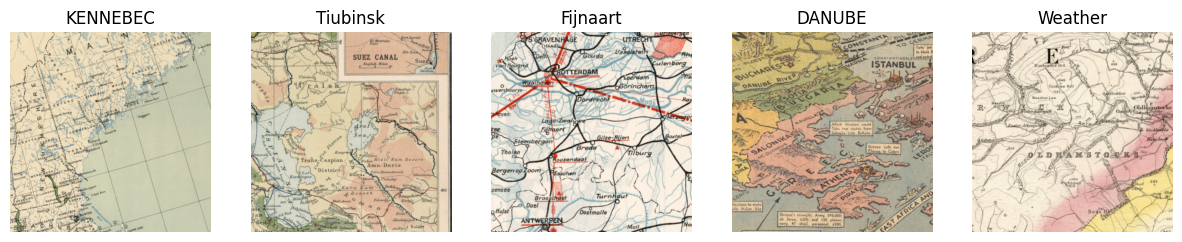

In [7]:
import matplotlib.pyplot as plt

def show_samples(dataloader, processor, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 10))
    for i, batch in enumerate(dataloader):
        images, texts = batch['image'], batch['text']
        for j in range(num_samples):
            ax = axs[j]
            img = images[j].permute(1, 2, 0)  # Change (C, H, W) to (H, W, C) for plotting
            ax.imshow(img.numpy())
            ax.set_title(texts[j])
            ax.axis('off')
        plt.show()
        break  # Only show the first batch

# Call the function with your DataLoader
show_samples(train_dataloader, processor)

In [8]:
def inspect_text_tokenization(dataloader, tokenizer, num_samples=5):
    for i, batch in enumerate(dataloader):
        texts = batch['text']
        for j in range(min(num_samples, len(texts))):
            print(f"Original Text: {texts[j]}")
            tokenized_output = tokenizer(texts[j], return_tensors="pt", padding="max_length", truncation=True, max_length=128)
            print(f"Tokenized Text: {tokenized_output.input_ids}")
            print(f"Attention Mask: {tokenized_output.attention_mask}")
        break  # Only check the first batch

# Call the function to inspect the tokenization
tokenizer = processor.tokenizer
inspect_text_tokenization(train_dataloader, tokenizer)


Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Transformed image size: torch.Size([3, 384, 384])
Original Text: Somosierra
Tokenized Text: tensor([[    0,   104,  1075,   366, 37511,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,


In [10]:
model.config.decoder_start_token_id = tokenizer.cls_token_id

## Start Training

In [ ]:
from tqdm import tqdm  # For a nice progress bar
import torch

def train(model, dataloader, optimizer, criterion, device, num_epochs=3):
    model.train()  # Set the model to training mode
    model.to(device)  # Send the model to the appropriate device (GPU or CPU)

    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

        for batch in progress_bar:
            images = batch['image'].to(device)
            # Prepare labels and attention mask for correct processing
            labels = [tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128).input_ids.squeeze(0) for text in batch['text']]
            labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=processor.tokenizer.pad_token_id).to(device)

            # Forward pass
            outputs = model(pixel_values=images, labels=labels)
            loss = outputs.loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update total loss and progress bar
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(dataloader)
        print(f"Average loss after epoch {epoch + 1}: {avg_loss:.4f}")

# Parameters and model preparations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss(ignore_index=processor.tokenizer.pad_token_id)

# Start training
num_epochs = 3  # You can adjust this depending on how long you want to train
train(model, train_dataloader, optimizer, criterion, device, num_epochs)
